# Vehicle Classifier #

Creating the Linear Support Vector Machine that will be used for vehicle detection

## Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from lane_finding import *
from plot_images import *
from vehicle_features import *

## Preparing the Training Data ##

The training data features are in the following order (functions in vehicle_features.py):
1. HOG
2. Color binning
3. Color histogram

In [2]:
def getTrainingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        images.append(img)
    return images

#Not Cars
nots = getTrainingImages('training_images/non-vehicles/Extras/*.png')
nots = nots+getTrainingImages('training_images/non-vehicles/GTI/*.png')
print("{} not-car training images".format(len(nots)))

#Cars
cars = getTrainingImages('training_images/vehicles/GTI_Far/*.png')
cars = cars+getTrainingImages('training_images/vehicles/GTI_Left/*.png')
cars = cars+getTrainingImages('training_images/vehicles/GTI_MiddleClose/*.png')
cars = cars+getTrainingImages('training_images/vehicles/GTI_Right/*.png')
cars = cars+getTrainingImages('training_images/vehicles/KITTI_extracted/*.png')
print("{} car training images".format(len(cars)))

8968 not-car training images
8792 car training images


## Camera Calibration for lane finding

In [3]:
cameraMtx, distCoeffs = calibrateCamera()

Calibration points found in 17 of 20 images


## Parameters/constants for feature extraction

In [4]:
COLOR_SPACE_IN = 'RGB'
HOG_ORIENT = 9 
HOG_PIX_PER_CELL = 8
HOG_CELLS_PER_BLOCK = 2
SPATIAL_SIZE = (24, 24)
HIST_BINS = 40

_Testing/Plotting Cells:_

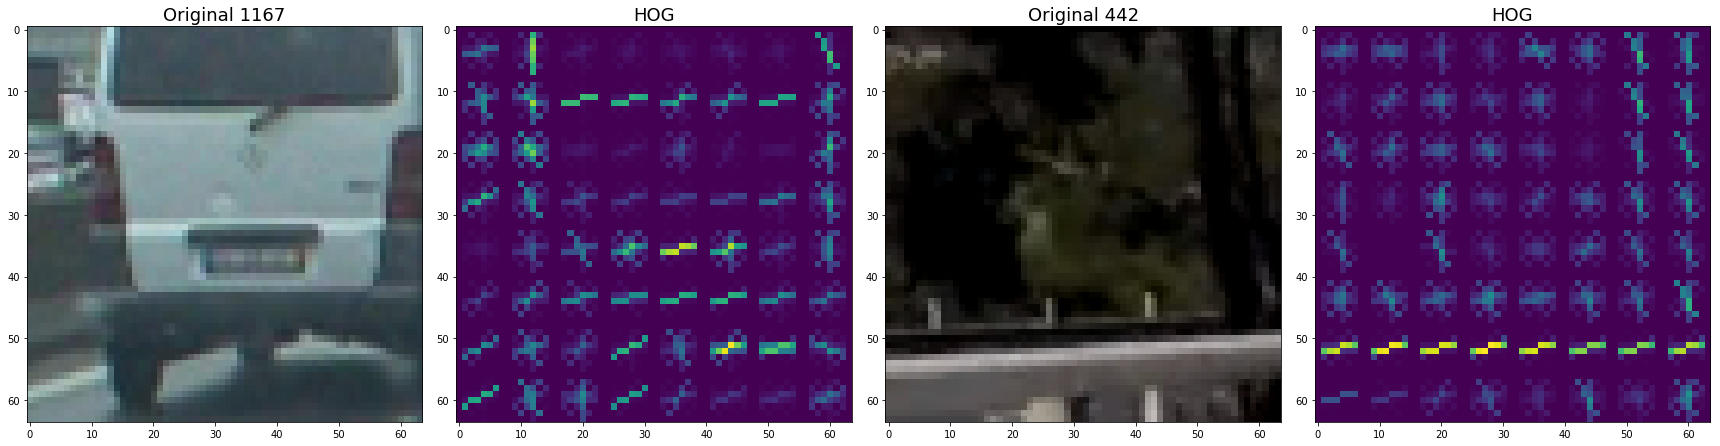

In [5]:
# Test extractions with visualization
car_idx = np.random.randint(0, len(cars))
not_idx = np.random.randint(0, len(nots))

car_features, car_hog = extractImgFeatures(cars[car_idx], COLOR_SPACE_IN, HOG_ORIENT, 
                                           HOG_PIX_PER_CELL, HOG_CELLS_PER_BLOCK, 
                                           SPATIAL_SIZE, HIST_BINS, vis=True, hog_channel=0)
not_features, not_hog = extractImgFeatures(nots[not_idx], COLOR_SPACE_IN, HOG_ORIENT, 
                                           HOG_PIX_PER_CELL, HOG_CELLS_PER_BLOCK, 
                                           SPATIAL_SIZE, HIST_BINS, vis=True, hog_channel=0)

plotMany(1,4, [cars[car_idx], car_hog, nots[not_idx], not_hog],
         ["Original {}".format(car_idx),'HOG',"Original {}".format(not_idx), 'HOG'], 
         [None,None,None,None])

In [6]:
#Extract the features
notcar_features = extractFeatures(nots, COLOR_SPACE_IN,  
                                  HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELLS_PER_BLOCK, 
                                  SPATIAL_SIZE, HIST_BINS)
car_features = extractFeatures(cars, COLOR_SPACE_IN, 
                               HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELLS_PER_BLOCK, 
                               SPATIAL_SIZE, HIST_BINS)

# Column scaling for X
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Y Labels (1 = car, 0 = notcar)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.1, 
                                                    random_state=rand_state)

## Training the SVC ##

In [7]:
svc = LinearSVC()

# training with a "stopwatch" running
t=time.time()
svc.fit(X_train, y_train)

print('Training classifier:')
print("\t* {} feature vectors".format(len(X_train[0])))
print("\t* Duration {:.4f} seconds".format(time.time()-t))
print("\t* Accuracy of {:.4f}".format(svc.score(X_test, y_test)))

Training classifier:
	* 7140 feature vectors
	* Duration 15.0747 seconds
	* Accuracy of 0.9842


## Detecting Vehicles ##

In [8]:
# Read in the testing images
def getTestingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        images.append(img)
    return images

testImages = getTestingImages('test_images/test*.jpg')  
testTitles = []
testCmap = []
for i in range(0, len(testImages)):
    testTitles.append("Test #{}".format(i))
    testCmap.append(None)

### Sliding Windows

In [9]:
#Constants for finding cars within WINDOWs
WINDOW = 64
N_WINDOW_BLOCKS = (WINDOW // HOG_PIX_PER_CELL) - HOG_CELLS_PER_BLOCK + 1
N_CELL_PER_STEP = 2

def findCars(img, scale, y_start, y_stop, vis=False):
    #Use the features to find cars in an image
    if vis:img_visualise = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    # Adjust for .jpg vs the .png used for training
    img = img.astype(np.float32)/255
    
    imgRoi = convertColorSpace(img[y_start:y_stop,:,:], COLOR_SPACE_IN)
    if scale != 1:
        imshape = imgRoi.shape
        imgRoi = cv2.resize(imgRoi, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
                
    ch1 = imgRoi[:,:,0]
    ch2 = imgRoi[:,:,1]
    ch3 = imgRoi[:,:,2]
    
    # Define blocks and steps
    n_xBlocks = (ch1.shape[1] // HOG_PIX_PER_CELL) + 1
    n_yBlocks = (ch1.shape[0] // HOG_PIX_PER_CELL) - HOG_CELLS_PER_BLOCK + 1 
    n_xSteps = (n_xBlocks - N_WINDOW_BLOCKS) // N_CELL_PER_STEP
    n_ySteps = (n_yBlocks - N_WINDOW_BLOCKS) // N_CELL_PER_STEP
    
    # Compute individual channel HOG features for the entire image
    hog1 = extractHog(ch1, HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELLS_PER_BLOCK, 
                      vis=False, feature_vec=False)
    hog2 = extractHog(ch2, HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELLS_PER_BLOCK,
                      vis=False, feature_vec=False)
    hog3 = extractHog(ch3, HOG_ORIENT, HOG_PIX_PER_CELL, HOG_CELLS_PER_BLOCK,
                      vis=False, feature_vec=False)
    
    for xb in range(n_xSteps):
        for yb in range(n_ySteps):
            ypos = yb*N_CELL_PER_STEP
            xpos = xb*N_CELL_PER_STEP
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+N_WINDOW_BLOCKS, xpos:xpos+N_WINDOW_BLOCKS].ravel() 
            hog_feat2 = hog2[ypos:ypos+N_WINDOW_BLOCKS, xpos:xpos+N_WINDOW_BLOCKS].ravel() 
            hog_feat3 = hog3[ypos:ypos+N_WINDOW_BLOCKS, xpos:xpos+N_WINDOW_BLOCKS].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*HOG_PIX_PER_CELL
            ytop = ypos*HOG_PIX_PER_CELL

            # Extract the image patch
            imgSub = cv2.resize(imgRoi[ytop:ytop+WINDOW, xleft:xleft+WINDOW], (64,64))
          
            # Get color features
            spatial_features = binColorsSpatially(imgSub, SPATIAL_SIZE)
            hist_features = computeColorHistogram(imgSub, HIST_BINS)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(
                (hog_features, spatial_features, hist_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ybox_top = np.int(ytop*scale)+y_start
                frame = np.int(WINDOW*scale)
                heatmap[ybox_top:ybox_top+frame,xbox_left:xbox_left+frame] += 1
                
                if vis:
                    cv2.rectangle(img_visualise, (xbox_left, ybox_top), 
                                  (xbox_left+frame, ybox_top+frame), (0,0,255), 6) 
                
    if vis:
        return img_visualise, heatmap
    else:
        return heatmap

_Testing/Plotting Cell:_

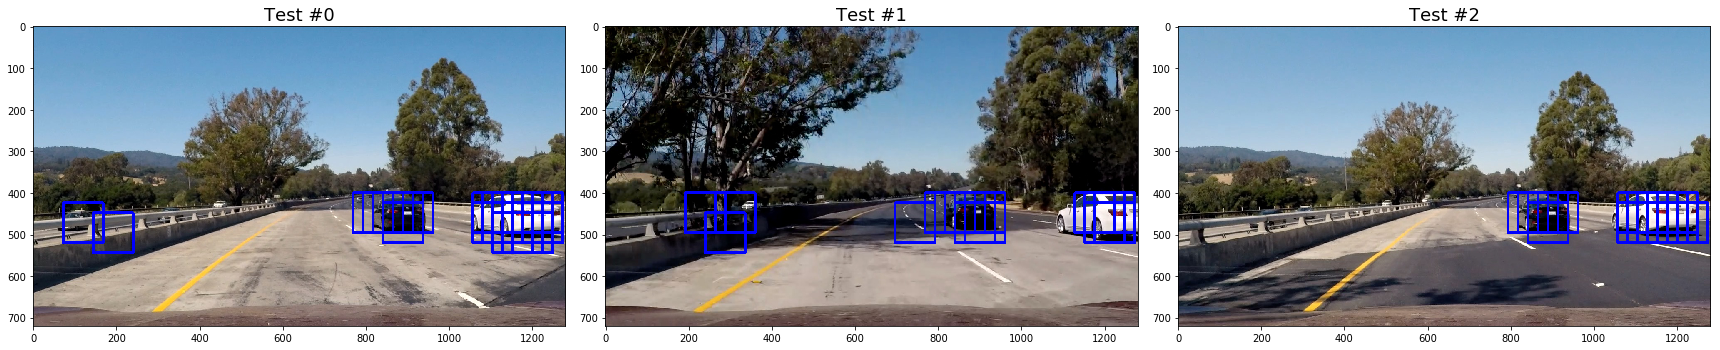

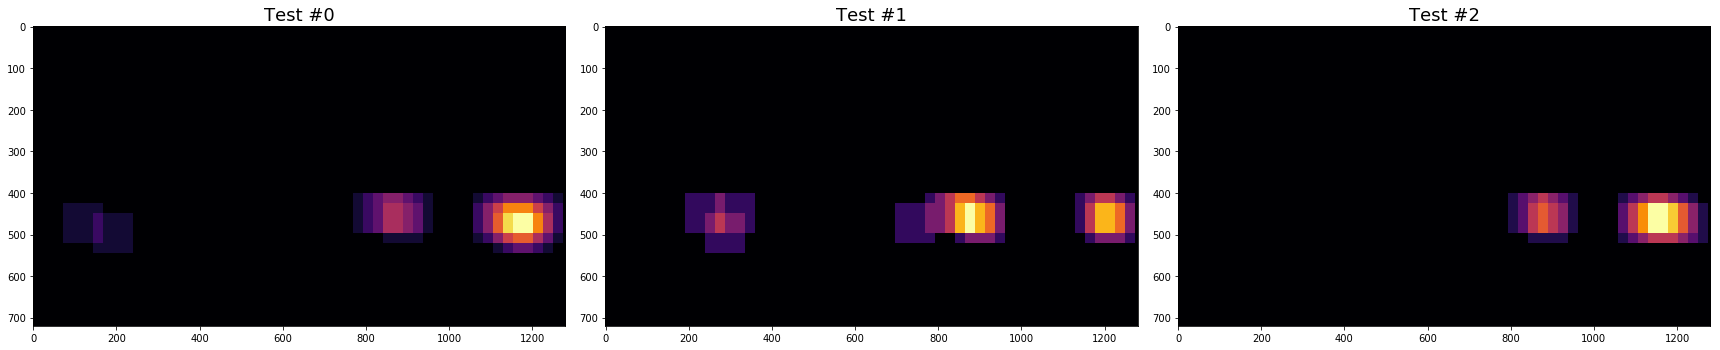

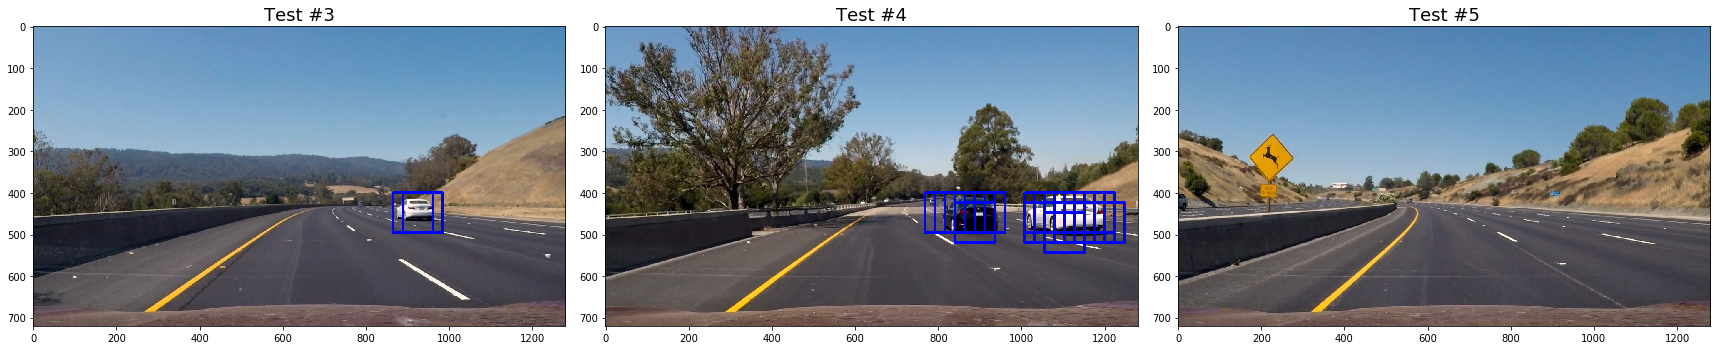

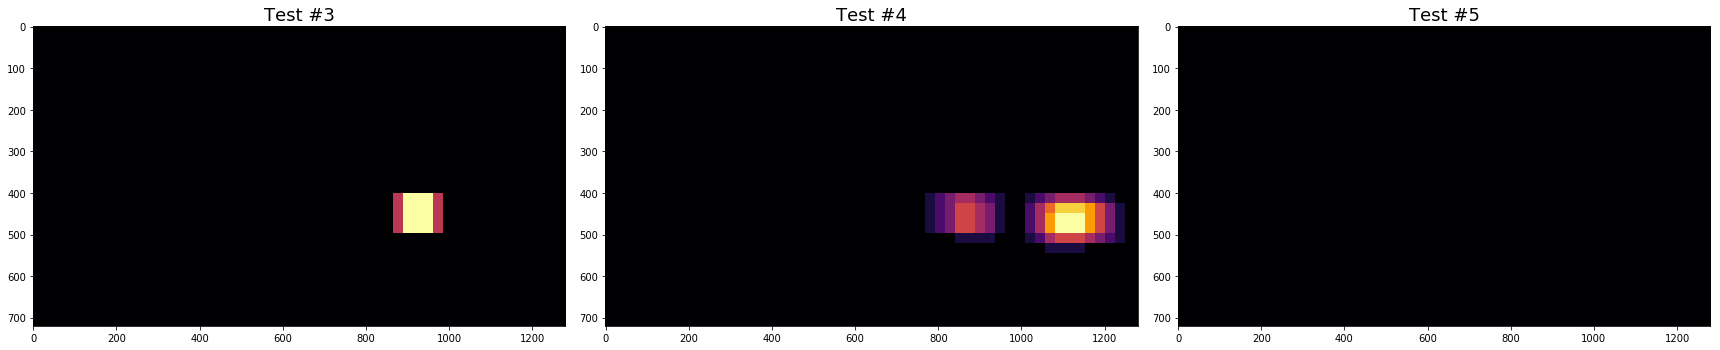

In [10]:
testResults = []
testHeatmaps = []

for img in testImages:
    result, heatmap = findCars(img, 1.5, 400, 600, vis=True)
    testResults.append(result)
    testHeatmaps.append(heatmap)

plotMany(1,3, testResults[0:3], testTitles[0:3], testCmap[0:3])
plotMany(1,3, testHeatmaps[0:3], testTitles[0:3], ['inferno','inferno','inferno'])
plotMany(1,3, testResults[3:6], testTitles[3:6], testCmap[3:6])
plotMany(1,3, testHeatmaps[3:6], testTitles[3:6], ['inferno','inferno','inferno'])

### Thresholding and Bounding Boxes

In [11]:
MIN_BOX_WIDTH = 40

def thresholdHeatmap(heatmap, threshold):
    h_threshold = np.copy(heatmap)
    h_threshold[heatmap <= threshold] = 0
    return h_threshold

def determineBoundingBoxes(img, labels):
    bboxes = []
    for car_label in range(1, labels[1]+1):
        car_pixels = (labels[0] == car_label).nonzero()
        y_pixels = np.array(car_pixels[0])
        y_min = np.min(y_pixels)
        y_max = np.max(y_pixels)
        x_pixels = np.array(car_pixels[1])
        x_min = np.min(x_pixels)
        x_max = np.max(x_pixels)
        if (x_max - x_min) > MIN_BOX_WIDTH:
            bbox = ((x_min, y_min), (x_max, y_max))
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            bboxes.append(bbox)
    return img, bboxes

def drawBoundingBoxes(img, labels):
    img, bboxes = determineBoundingBoxes(img, labels)
    return img

_Testing/Plotting Cells:_

4 labels pre, 3 post-thresh


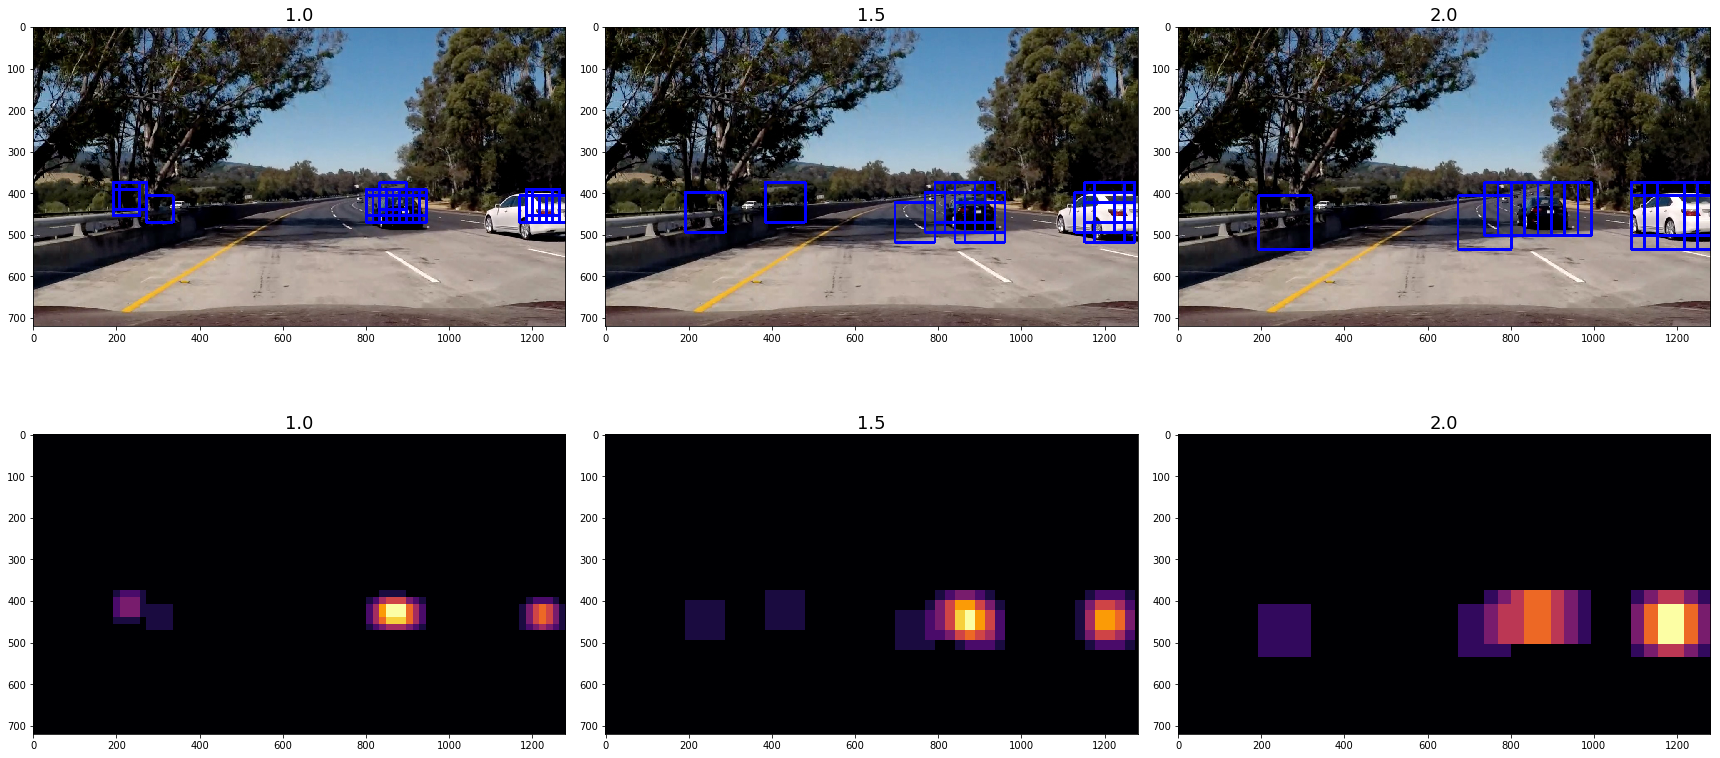

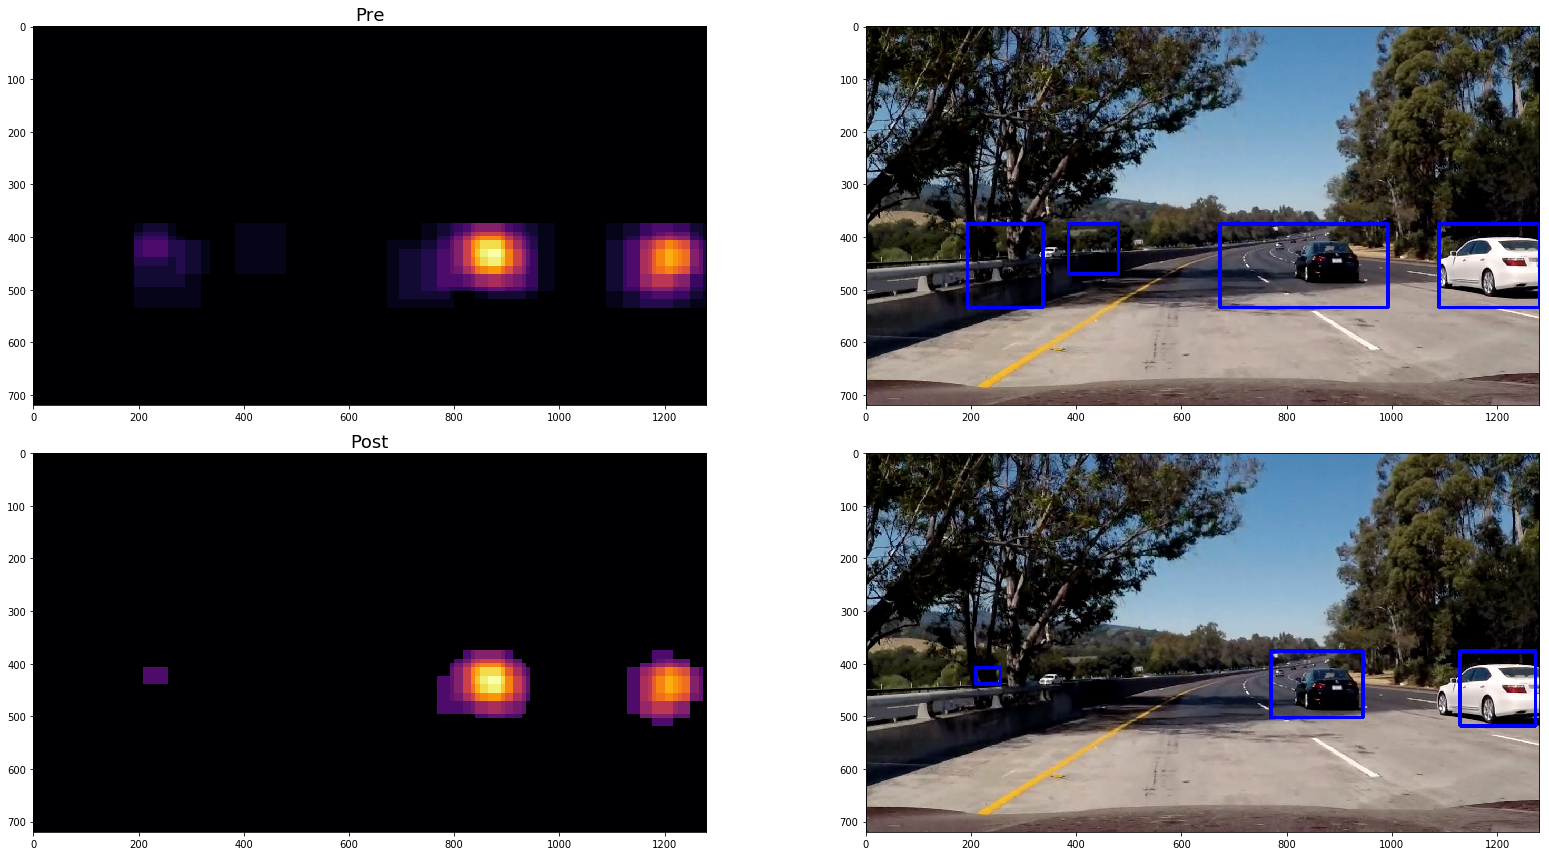

In [12]:
scales = [1.0, 1.5, 2.0]
y_starts = [375, 375, 375]
y_stops = [500, 550, 600]

h_pre = np.zeros_like(testImages[1][:,:,0])
rs = []
hs = []
titles_r = []
titles_h = []
cmaps_r = []
cmaps_h = []

for idx, s in enumerate(scales):
    r, h = findCars(testImages[1], s, y_starts[idx], y_stops[idx], vis=True)
    h_pre += h
    rs.append(r)
    hs.append(h)
    titles_r.append("{}".format(s))
    titles_h.append("{}".format(s))
    cmaps_r.append(None)
    cmaps_h.append('inferno')

l_pre = label(h_pre)
i_pre = drawBoundingBoxes(np.copy(testImages[1]), l_pre)

h_post = thresholdHeatmap(h_pre, len(scales)+1)
l_post = label(h_post)
i_post = drawBoundingBoxes(np.copy(testImages[1]), l_post)

print("{} labels pre, {} post-thresh".format(l_pre[1], l_post[1]))

plotMany(2,len(scales), rs+hs, titles_r+titles_h, cmaps_r+cmaps_h)
plotMany(2,2, [h_pre,i_pre,h_post,i_post], ['Pre','','Post',''],
         ['inferno',None,'inferno',None])

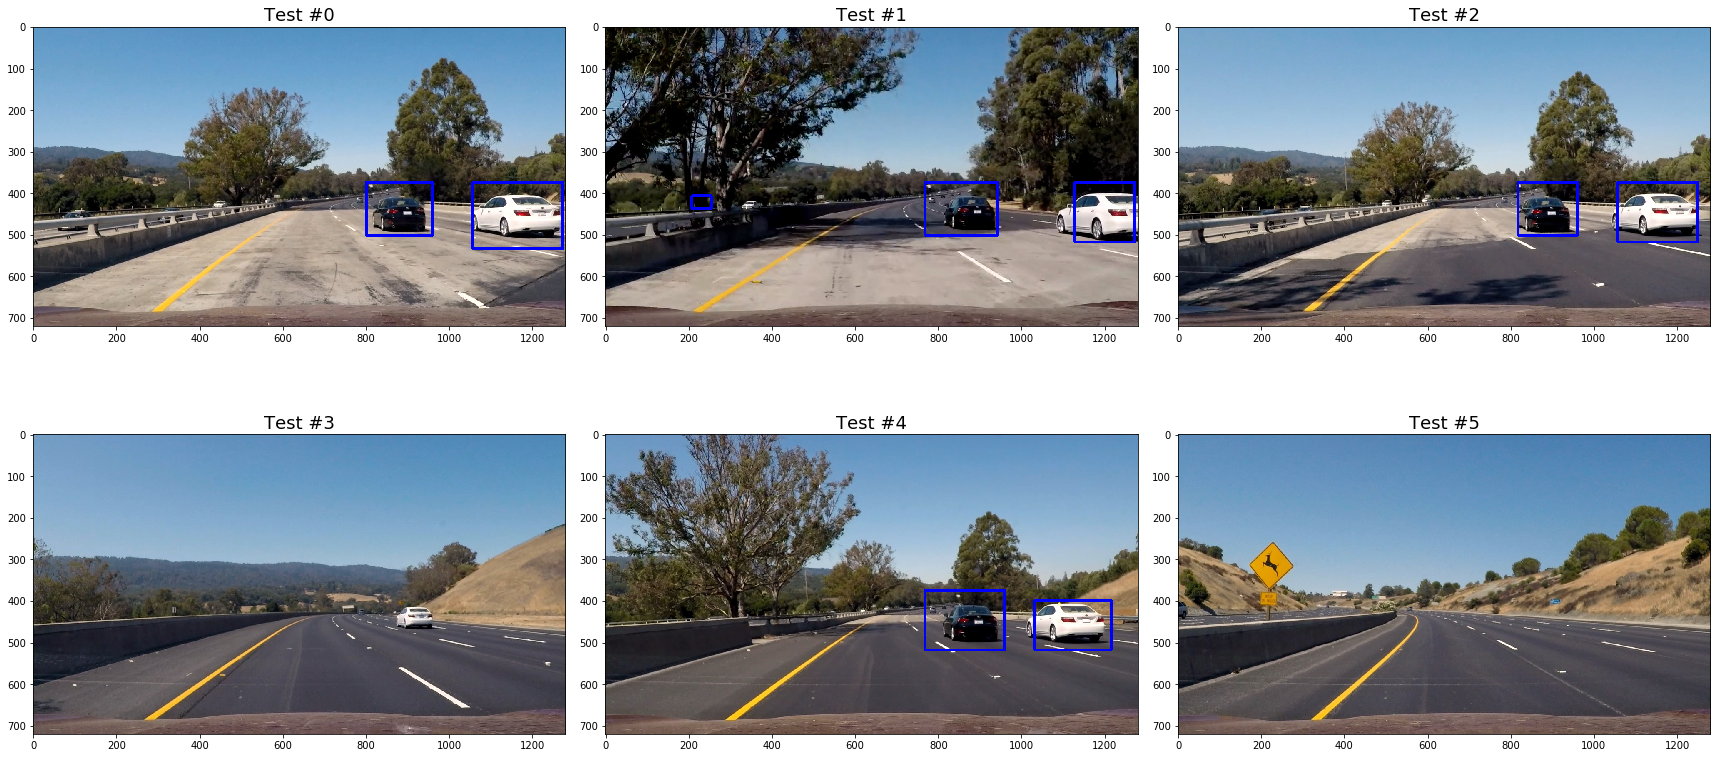

In [13]:
results = []
scales = [1.0, 1.5, 2.0]
y_starts = [375, 375, 375]
y_stops = [500, 550, 600]

for idx, img in enumerate(testImages):
    heatmap = np.zeros_like(img[:,:,0])
    for idx, s in enumerate(scales):
        h = findCars(img, s, y_starts[idx], y_stops[idx])
        heatmap += h
    heatmap = thresholdHeatmap(heatmap, len(scales)+1)
    labels = label(heatmap)
    bboxResult = drawBoundingBoxes(np.copy(img), labels)
    results.append(bboxResult)

plotMany(2,3, results, testTitles, testCmap)

### Vehicle Detection History

In [14]:
class TrackHeatmap():
    def __init__(self, thresh):
        self.init = False
        
        #Exponential smoothing on the heatmap
        self.latest = []
        self.smoothed = []
        self.alpha = 0.40       
        
        self.threshold = thresh
        return
    
    def initialize(self, heatmap):
        self.smoothed = thresholdHeatmap(heatmap, self.threshold)
        self.init = True
        return
    
    def reset(self):
        self.init = False
        return
    
    def update(self, heatmap, visualise):
        #Use EMA to record and smooth the heatmap
        self.latest = heatmap
        if not self.init:
            self.initialize(heatmap)
            return self.smoothed
        s_previous = np.multiply(1-self.alpha, self.smoothed)
        s_present = np.multiply(self.alpha, heatmap)
        s_t = np.add(s_previous, s_present)            
        self.smoothed = thresholdHeatmap(s_t, self.threshold)
        
        if visualise:
            plotMany(1,4, [s_previous, s_present, s_t, self.smoothed], 
                     ['Previous', 'Present', 'Smoothed', 'Thresholded'],
                     ['inferno', 'inferno', 'inferno', 'inferno'])
        return self.smoothed
        
    def addVehiclesHeat(self, bboxes):
        #Add in additional heat from bounded vehicles
        for b in bboxes:
            x_min, y_min = b[0]
            x_max, y_max = b[1]
            self.smoothed[y_min:y_max,x_min:x_max] += self.latest[y_min:y_max,x_min:x_max]
        return
        

## Vehicle Tracking Pipeline ##

In [15]:
WINDOW_SCALES = [1.0, 1.5, 2.0]
Y_STARTS = [375, 375, 375]
Y_STOPS = [500, 550, 600]
HEAT_THRESHOLD = len(WINDOW_SCALES)
heatmapper = TrackHeatmap(HEAT_THRESHOLD)
leftLane = LaneLine(True)
rightLane = LaneLine(False)

def processImage(img, vis=False):
    heatmap = np.zeros_like(img[:,:,0])
    for i, s in enumerate(WINDOW_SCALES):
        heatmap += findCars(img, s, Y_STARTS[i], Y_STOPS[i])
    h_smoothed = heatmapper.update(heatmap, vis)
    labels = label(h_smoothed)
    i_bbox, bboxes = determineBoundingBoxes(np.copy(img), labels)
    i_everything = findLanes(i_bbox, leftLane, rightLane, 
                             cameraMtx, distCoeffs)
    heatmapper.addVehiclesHeat(bboxes)
    return i_everything

_Testing/Plotting Cell:_

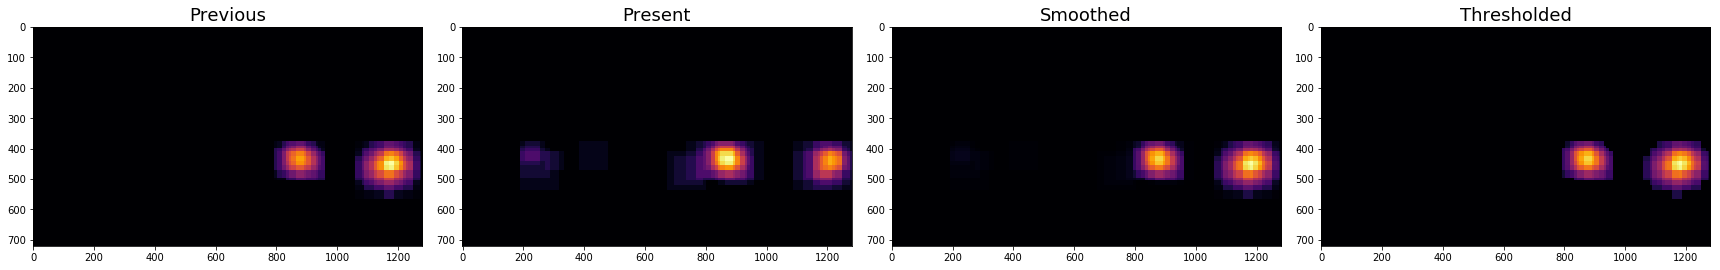

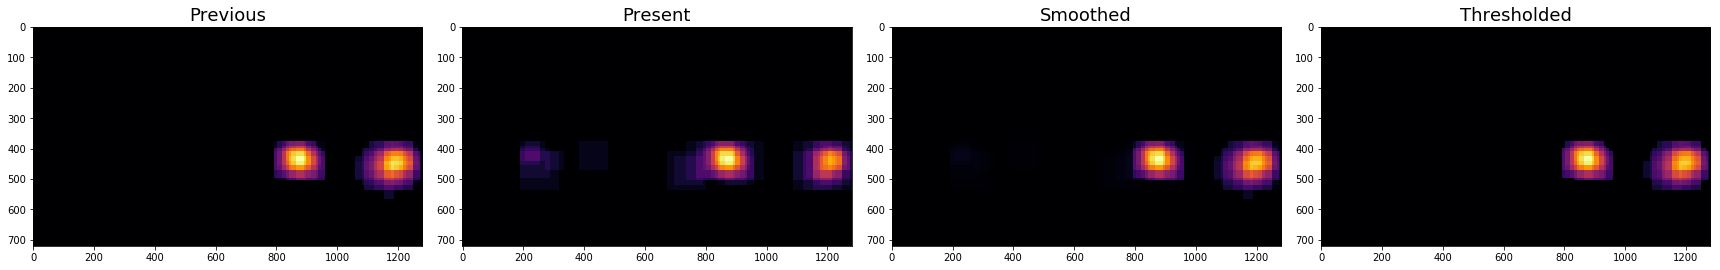

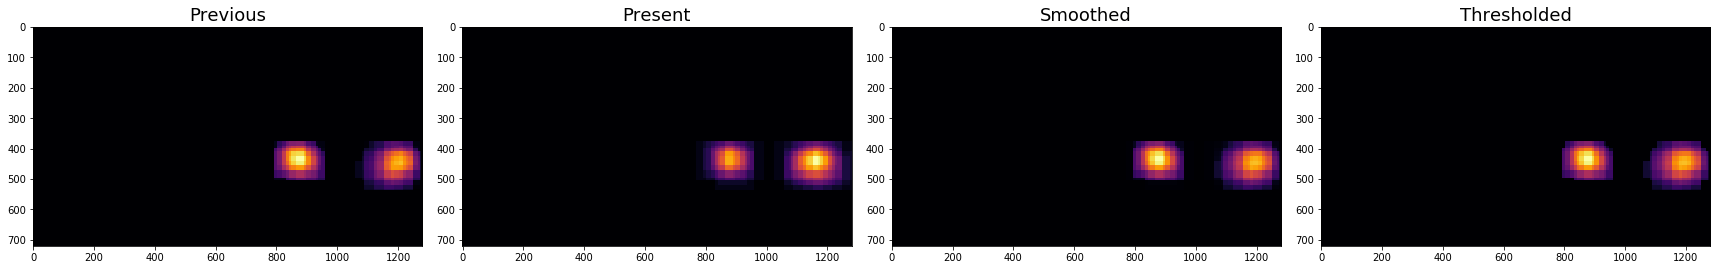

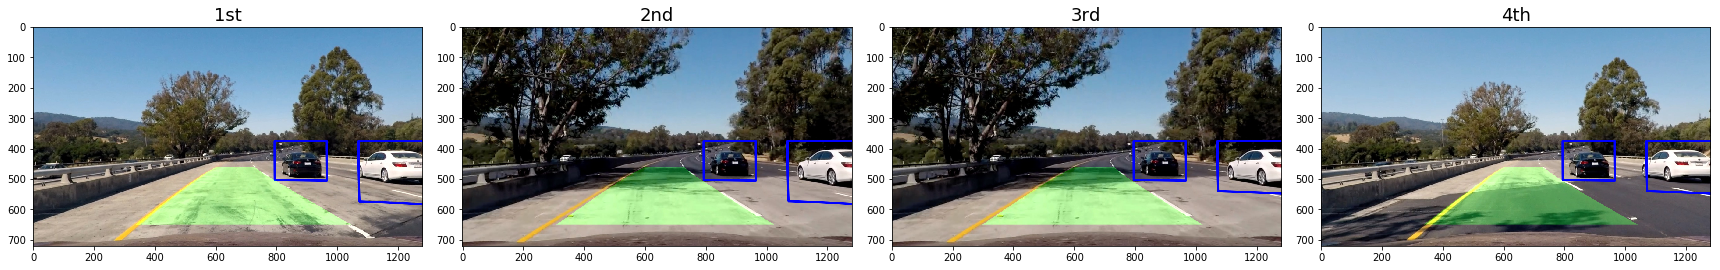

In [16]:
heatmapper.reset()
img_bbox1 = processImage(testImages[0], vis=True)
img_bbox2 = processImage(testImages[1], vis=True)
img_bbox3 = processImage(testImages[1], vis=True)
img_bbox4 = processImage(testImages[2], vis=True)
plotMany(1,4, [img_bbox1,img_bbox2,img_bbox3,img_bbox4], 
         ['1st','2nd','3rd','4th'], [None,None,None,None])

### Video Processing ###

In [17]:
def processVideo(videoName, outputName, startTime=None, stopTime=None):
    # Remove any artifacts from previous runs
    heatmapper.reset()
    leftLane.reset()
    rightLane.reset()
    
    #Process the whole
    if startTime == None:
        clip1 = VideoFileClip(videoName)
    else:
        clip1 = VideoFileClip(videoName).subclip(startTime,stopTime)
        
    projectClip = clip1.fl_image(processImage)
    %time projectClip.write_videofile(outputName, audio=False)

_Testing/Plotting Cells:_

In [18]:
testing = 'output_images/test_results.mp4'
processVideo("test_video.mp4", testing)

HTML("""
<video width="320" height="180" controls>
  <source src="{0}">
</video>
""".format(testing))

[MoviePy] >>>> Building video output_images/test_results.mp4
[MoviePy] Writing video output_images/test_results.mp4


 97%|█████████▋| 38/39 [00:25<00:00,  1.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_results.mp4 

CPU times: user 34.6 s, sys: 204 ms, total: 34.8 s
Wall time: 26.5 s


In [19]:
#Just testing smaller portions
subclip = 'output_images/sub_results.mp4'
processVideo("project_video.mp4", subclip, 0, 30)

HTML("""
<video width="320" height="180" controls>
  <source src="{0}">
</video>
""".format(subclip))

[MoviePy] >>>> Building video output_images/sub_results.mp4
[MoviePy] Writing video output_images/sub_results.mp4


100%|█████████▉| 750/751 [08:23<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/sub_results.mp4 

CPU times: user 11min 22s, sys: 1.67 s, total: 11min 23s
Wall time: 8min 24s


In [20]:
project = 'output_images/project_results.mp4'
processVideo("project_video.mp4", project)

HTML("""
<video width="320" height="180" controls>
  <source src="{0}">
</video>
""".format(project))

[MoviePy] >>>> Building video output_images/project_results.mp4
[MoviePy] Writing video output_images/project_results.mp4


100%|█████████▉| 1260/1261 [14:09<00:00,  1.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_results.mp4 

CPU times: user 19min 29s, sys: 2.39 s, total: 19min 32s
Wall time: 14min 9s
